In [1]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, AncillaRegister, ClassicalRegister

from qiskit.quantum_info import Operator

import numpy as np

In [2]:
def wire_order_maker(d):
    if (not isinstance(d, int)) or d < 1:
        raise TypeError(f"silly you: bad input")
        return 0
    if d < 3:
        wire_order = np.arange(d)
    else:
        wire_order = np.arange(2 * d - 2)
        wire_order[2::2], wire_order[3::2] = np.arange(d, 2 * d - 2), np.arange(2, d)
    return list(wire_order)

In [3]:
def shift_matrix(k, d):
    S_k = np.zeros((1 << d, 1 << d), dtype=int)
    for idx, row in enumerate(S_k[:k]):
        row[idx - k] = 1
    for idx, row in enumerate(S_k[k:]):
        row[idx] = 1

    return S_k

# without measurements & with regular Toffolis

In [4]:
def measurement_free_quantum_shifter(k, d):
    if ((not isinstance(d, int)) or d < 1) or (not isinstance(k, int)):
        raise TypeError(f"silly you: bad input")
        return 0

    k %= 1 << d

    qregx = QuantumRegister(d, "x")
    quantum_shifter_circuit = QuantumCircuit(qregx, name=f"{d}-bit {k}-shifter")

    if d < 3: # these are Clifford
        if d == 1 and k == 1:
            quantum_shifter_circuit.x(qregx[0])
        if d == 2:
            if k == 1:
                quantum_shifter_circuit.cx(qregx[0], qregx[1])
                quantum_shifter_circuit.x(qregx[0])
            if k == 2:
                quantum_shifter_circuit.x(qregx[1])
            if k == 3:
                quantum_shifter_circuit.x(qregx[0])
                quantum_shifter_circuit.cx(qregx[0], qregx[1])
        return quantum_shifter_circuit

    qcarry = AncillaRegister(d - 2, "carry")
    quantum_shifter_circuit.add_register(qcarry)

    if k == 0:
        return quantum_shifter_circuit

    least_significant_bit = (k&-k).bit_length() - 1 # at least 0

    if least_significant_bit > 0:
        quantum_shifter_circuit.compose(measurement_free_quantum_shifter(k >> least_significant_bit, d - least_significant_bit), qubits=qregx[least_significant_bit:] + qcarry[least_significant_bit:], inplace=True)
        return quantum_shifter_circuit

    if k >> (d - 2) != 0:
        quantum_shifter_circuit.compose(measurement_free_quantum_shifter(k >> (d - 2), 2), qubits=qregx[-2:], inplace=True)
        k %= 1 << (d - 2)

    k_middle_bits = (k >> np.arange(1, d - 1))%2

    if k_middle_bits[0] == 1:
        quantum_shifter_circuit.x(qregx[:2])

    quantum_shifter_circuit.ccx(qregx[0], qregx[1], qcarry[0])

    for idx in range(1, d - 2):
        if k_middle_bits[idx]^k_middle_bits[idx-1] == 1:
            quantum_shifter_circuit.x(qcarry[idx - 1])
        if k_middle_bits[idx]:
            quantum_shifter_circuit.x(qregx[idx + 1])
        quantum_shifter_circuit.ccx(qcarry[idx - 1], qregx[idx + 1], qcarry[idx])

    quantum_shifter_circuit.cx(qcarry[- 1], qregx[- 1])

    for idx in range(d - 3, 0, - 1):
        quantum_shifter_circuit.ccx(qcarry[idx - 1], qregx[idx + 1], qcarry[idx])
        quantum_shifter_circuit.cx(qcarry[idx - 1], qregx[idx + 1])
        if k_middle_bits[idx]^k_middle_bits[idx-1] == 1:
            quantum_shifter_circuit.x(qcarry[idx - 1])
        if k_middle_bits[idx] == 1:
            quantum_shifter_circuit.x(qregx[idx + 1])

    quantum_shifter_circuit.ccx(qregx[0], qregx[1], qcarry[0])

    if k_middle_bits[0] == 1:
        quantum_shifter_circuit.cx(qregx[0], qregx[1])
        quantum_shifter_circuit.x(qregx[1])
    else:
        quantum_shifter_circuit.cx(qregx[0], qregx[1])
        quantum_shifter_circuit.x(qregx[0])

    return quantum_shifter_circuit

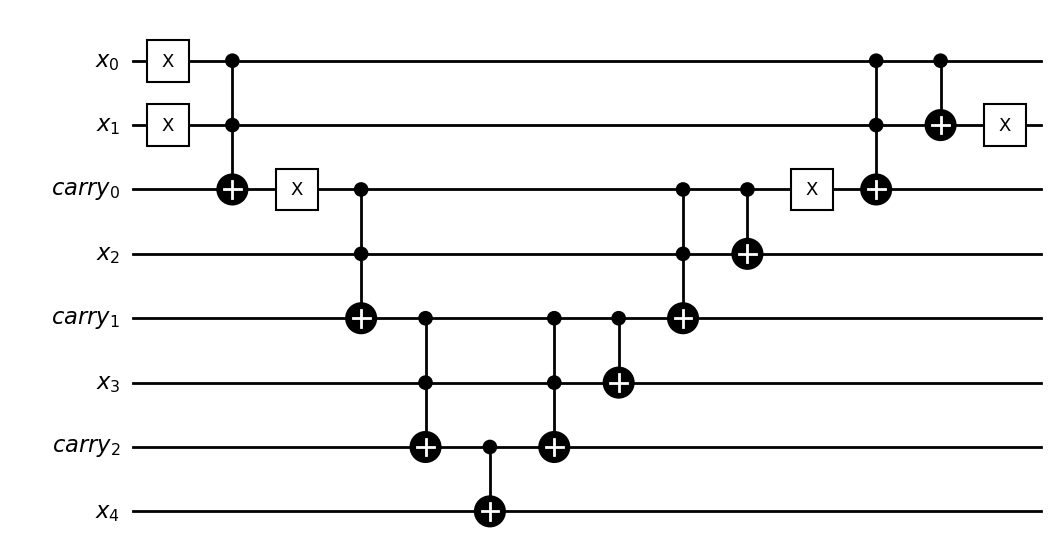

In [5]:
k, d = 3, 5
measurement_free_quantum_shifter(k, d).draw(output="mpl", style="bw", wire_order=wire_order_maker(d))

In [6]:
U = np.array(Operator(measurement_free_quantum_shifter(k, d)))[np.ix_(np.arange(1 << d), np.arange(1 << d))] # operator matrix, assuming zero ancillas
np.array_equal(U, shift_matrix(k, d))

True

In [7]:
d = 6
for k in range(1 << d):
    U = np.array(Operator(measurement_free_quantum_shifter(k, d)))[np.ix_(np.arange(1 << d), np.arange(1 << d))] # operator matrix, assuming zero ancillas
    if not np.array_equal(U, shift_matrix(k, d)):
        print(k)

In [8]:
def compute_carry():
    qcontrol, qtarget = QuantumRegister(2, "ctrl"), AncillaRegister(1, "trgt")

    compute_carry_gate = QuantumCircuit(qcontrol, qtarget, name=f"compute carry")

    compute_carry_gate.h(qtarget[0])
    compute_carry_gate.t(qtarget[0])

    compute_carry_gate.cx(qcontrol[0], qtarget[0])
    compute_carry_gate.cx(qcontrol[1], qtarget[0])
    compute_carry_gate.cx(qtarget[0], qcontrol[1])
    compute_carry_gate.cx(qtarget[0], qcontrol[0])

    compute_carry_gate.tdg(qcontrol)
    compute_carry_gate.t(qtarget[0])

    compute_carry_gate.cx(qtarget[0], qcontrol[0])
    compute_carry_gate.cx(qtarget[0], qcontrol[1])

    compute_carry_gate.h(qtarget[0])
    compute_carry_gate.s(qtarget[0])

    return compute_carry_gate

def uncompute_carry():
    qcontrol, qtarget, clreg = QuantumRegister(2, "ctrl"), AncillaRegister(1, "trgt"), ClassicalRegister(1, "clss")

    uncompute_carry_gate = QuantumCircuit(qcontrol, qtarget, clreg, name=f"right-Toffoli")

    uncompute_carry_gate.h(qtarget[0])

    uncompute_carry_gate.measure(qtarget[0], clreg[0])

    uncompute_carry_gate.cz(qcontrol[0], qcontrol[1]).c_if(clreg[0], 1)
    uncompute_carry_gate.x(qtarget[0]).c_if(clreg[0], 1)

    return uncompute_carry_gate

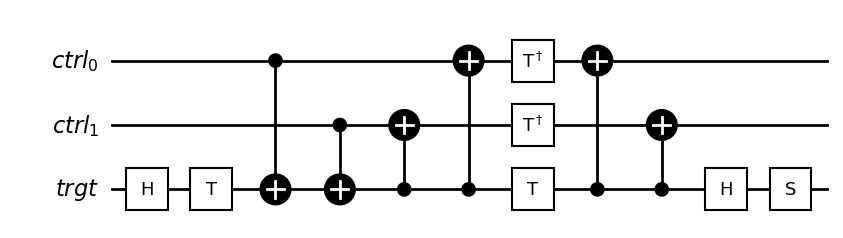

In [9]:
compute_carry().draw(output="mpl", style="bw")

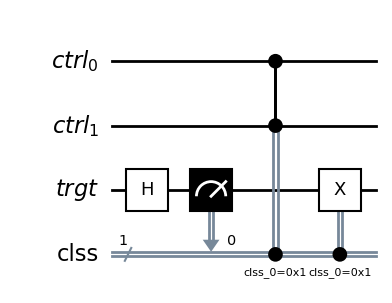

In [10]:
uncompute_carry().draw(output="mpl", style="bw")

In [11]:
def quantum_shifter(k, d):
    if ((not isinstance(d, int)) or d < 1) or (not isinstance(k, int)):
        raise TypeError(f"silly you: bad input")
        return 0

    k %= 1 << d

    qregx = QuantumRegister(d, "x")
    quantum_shifter_circuit = QuantumCircuit(qregx, name=f"{d}-bit {k}-shifter")

    if d < 3: # these are Clifford
        if d == 1 and k == 1:
            quantum_shifter_circuit.x(qregx[0])
        if d == 2:
            if k == 1:
                quantum_shifter_circuit.cx(qregx[0], qregx[1])
                quantum_shifter_circuit.x(qregx[0])
            if k == 2:
                quantum_shifter_circuit.x(qregx[1])
            if k == 3:
                quantum_shifter_circuit.x(qregx[0])
                quantum_shifter_circuit.cx(qregx[0], qregx[1])
        return quantum_shifter_circuit

    qcarry, clreg = AncillaRegister(d - 2, "carry"), ClassicalRegister(d - 2, "c")
    quantum_shifter_circuit.add_register(qcarry, clreg)

    if k == 0:
        return quantum_shifter_circuit

    least_significant_bit = (k&-k).bit_length() - 1 # at least 0

    if least_significant_bit > 0:
        quantum_shifter_circuit.compose(quantum_shifter(k >> least_significant_bit, d - least_significant_bit), qubits=qregx[least_significant_bit:] + qcarry[least_significant_bit:], clbits=clreg[least_significant_bit:], inplace=True)
        return quantum_shifter_circuit

    if k >> (d - 2) != 0:
        quantum_shifter_circuit.compose(quantum_shifter(k >> (d - 2), 2).to_gate(), qubits=qregx[-2:], inplace=True)
        k %= 1 << (d - 2)

    k_middle_bits = (k >> np.arange(1, d - 1))%2

    compute_carry_gate, uncompute_carry_gate = compute_carry().to_gate(), uncompute_carry()

    if k_middle_bits[0] == 1:
        quantum_shifter_circuit.x(qregx[:2])

    quantum_shifter_circuit.compose(compute_carry_gate, qubits=[qregx[0], qregx[1], qcarry[0]], inplace=True)

    for idx in range(1, d - 2):
        if k_middle_bits[idx]^k_middle_bits[idx-1] == 1:
            quantum_shifter_circuit.x(qcarry[idx - 1])
        if k_middle_bits[idx]:
            quantum_shifter_circuit.x(qregx[idx + 1])
        quantum_shifter_circuit.compose(compute_carry_gate, qubits=[qcarry[idx - 1], qregx[idx + 1], qcarry[idx]], inplace=True)

    quantum_shifter_circuit.cx(qcarry[- 1], qregx[- 1])

    for idx in range(d - 3, 0, - 1):
        quantum_shifter_circuit.compose(uncompute_carry_gate, qubits=[qcarry[idx - 1], qregx[idx + 1], qcarry[idx]], clbits=clreg[idx], inplace=True)
        quantum_shifter_circuit.cx(qcarry[idx - 1], qregx[idx + 1])
        if k_middle_bits[idx]^k_middle_bits[idx-1] == 1:
            quantum_shifter_circuit.x(qcarry[idx - 1])
        if k_middle_bits[idx] == 1:
            quantum_shifter_circuit.x(qregx[idx + 1])

    quantum_shifter_circuit.compose(uncompute_carry_gate, qubits=[qregx[0], qregx[1], qcarry[0]], clbits=clreg[0], inplace=True)

    if k_middle_bits[0] == 1:
        quantum_shifter_circuit.cx(qregx[0], qregx[1])
        quantum_shifter_circuit.x(qregx[1])
    else:
        quantum_shifter_circuit.cx(qregx[0], qregx[1])
        quantum_shifter_circuit.x(qregx[0])

    return quantum_shifter_circuit

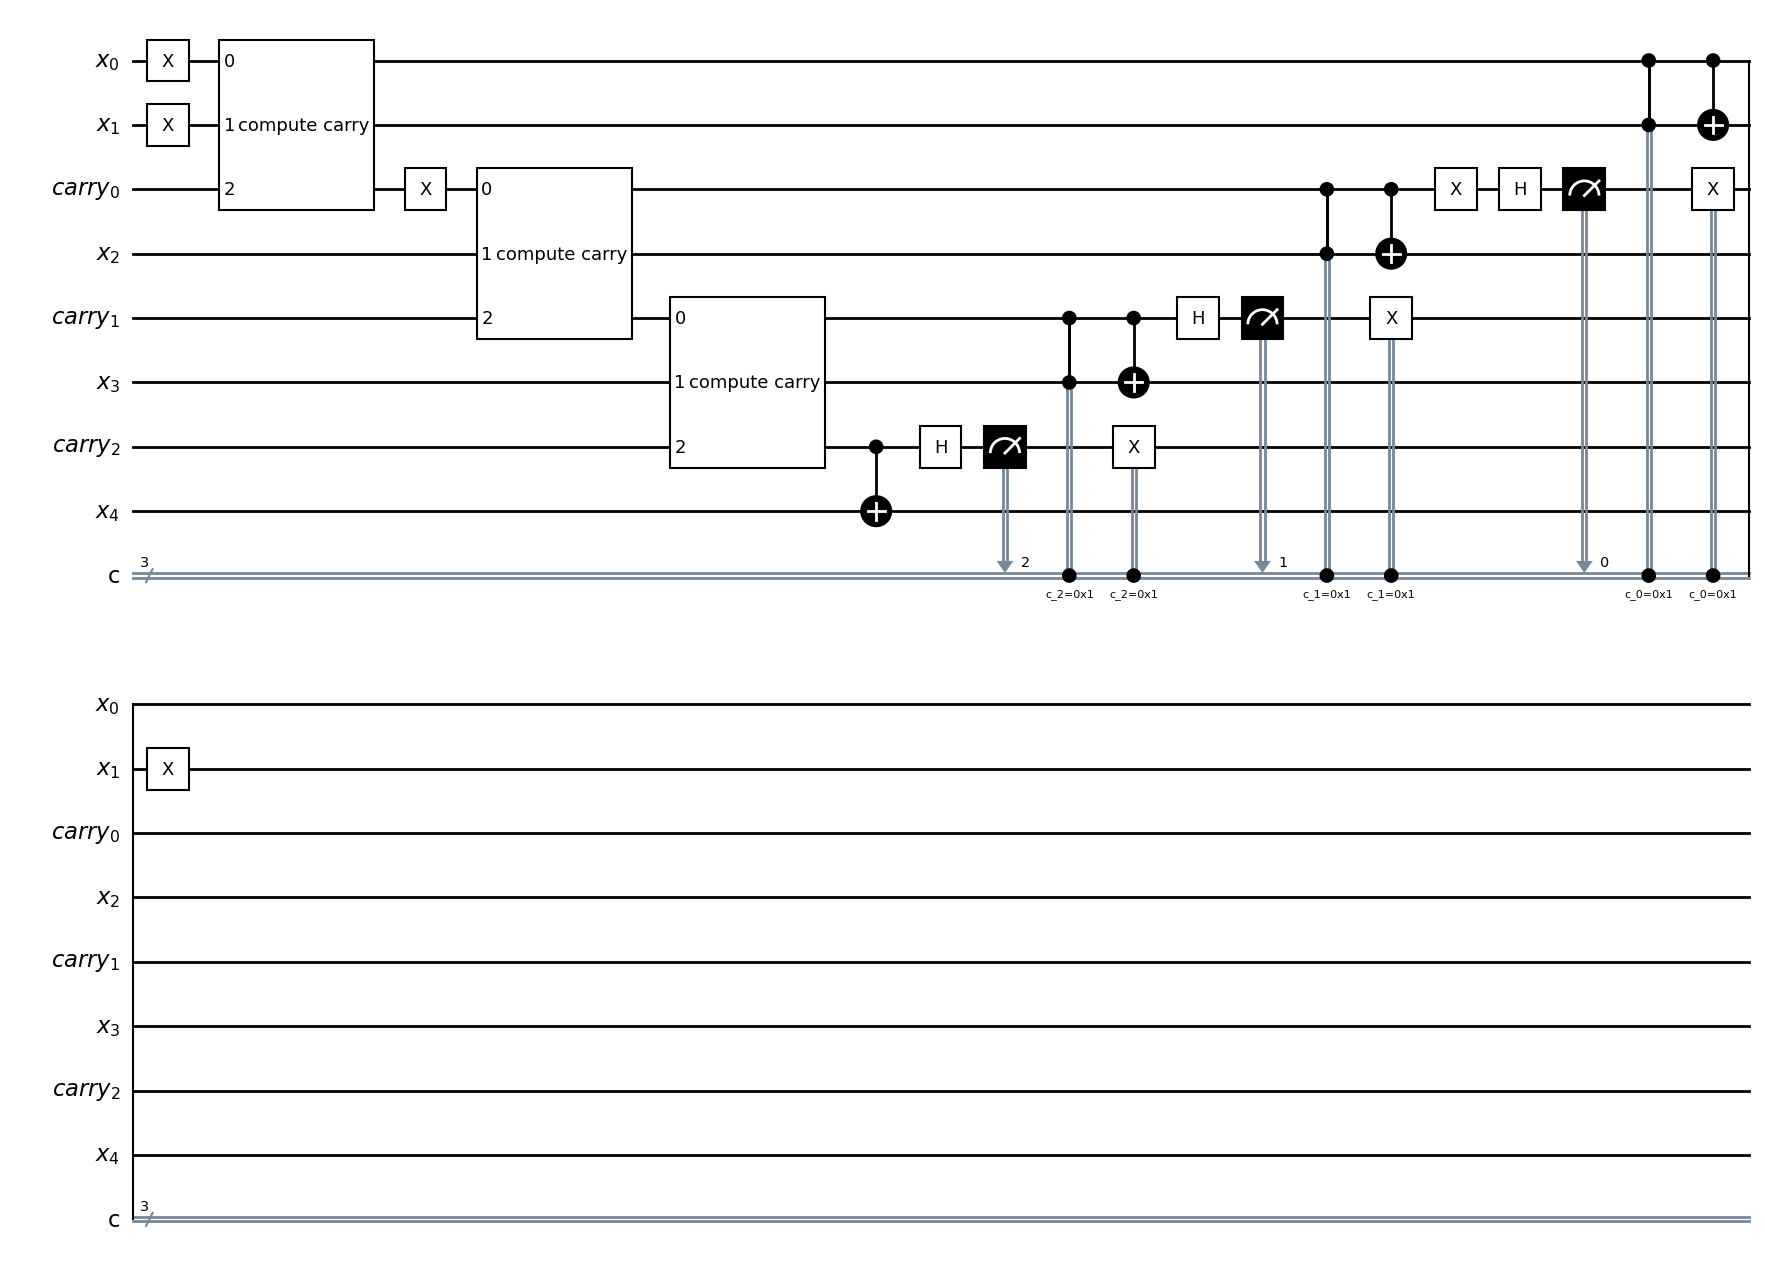

In [12]:
k, d = 3, 5
quantum_shifter(k, d).draw(output="mpl", style="bw", wire_order=wire_order_maker(d))

### Testing:

In [13]:
from qiskit import transpile
from qiskit_aer import AerSimulator

In [14]:
sim = AerSimulator()

In [15]:
k, d, x = 11, 5, 4 # addendum, number of bits, inital state

qregx = QuantumRegister(d, "q")
qcarry = AncillaRegister(d - 2, "a")
clreg = ClassicalRegister(d - 2, "c")
resreg = ClassicalRegister(d, "res") # for the final results

quantum_shifter_circuit = QuantumCircuit(qregx, qcarry, clreg, resreg, name="quantum {d}-bit {k}-shifter")

for idx, bit in enumerate((x >> np.arange(d))%2):
    if bit == 1:
        quantum_shifter_circuit.x(qregx[idx])

quantum_shifter_circuit.compose(quantum_shifter(k, d), qubits=qregx[:] + qcarry[:], clbits=clreg, inplace=True)

quantum_shifter_circuit.measure(qregx, resreg)

transpiled_circuit = transpile(quantum_shifter_circuit, backend=sim)

job = sim.run(transpiled_circuit, shots=1 << 10)

counts = job.result().get_counts()

#print(counts)

result = int(list(counts.keys())[0][:d], 2)

if result != (x + k)%(1 << d):
    print(f"x = {x}\tk = {k}\tx + k = {(x + k)%(1 << d)} (mod 1 << {d})\tresult = {result}")
else:
    print(f"no errors")

no errors


In [24]:
T = np.diag([np.exp(- np.pi * 1j / 8), np.exp(np.pi * 1j / 8)])
Tdg = T.conj().T
S = np.diag([np.exp(- np.pi * 1j / 4), np.exp(np.pi * 1j / 4)])
Z = np.diag([np.exp(- np.pi * 1j / 2), np.exp(np.pi * 1j / 2)])
H = np.array([[1, 1], [1, - 1]]) / np.sqrt(2)

In [25]:
T, Tdg, S, Z, H

(array([[0.92387953-0.38268343j, 0.        +0.j        ],
        [0.        +0.j        , 0.92387953+0.38268343j]]),
 array([[0.92387953+0.38268343j, 0.        -0.j        ],
        [0.        -0.j        , 0.92387953-0.38268343j]]),
 array([[0.70710678-0.70710678j, 0.        +0.j        ],
        [0.        +0.j        , 0.70710678+0.70710678j]]),
 array([[6.123234e-17-1.j, 0.000000e+00+0.j],
        [0.000000e+00+0.j, 6.123234e-17+1.j]]),
 array([[ 0.70710678,  0.70710678],
        [ 0.70710678, -0.70710678]]))

In [30]:
np.round(Tdg@H@T, 4)

array([[ 0.7071-0.j ,  0.5   +0.5j],
       [ 0.5   -0.5j, -0.7071-0.j ]])

In [28]:
H@S@H@Z

array([[ 4.32978028e-17-7.07106781e-01j,  7.07106781e-01-4.32978028e-17j],
       [-7.07106781e-01-4.32978028e-17j,  4.32978028e-17+7.07106781e-01j]])